In [2]:
using Random, StatsPlots, LaTeXStrings , ColorSchemes , Statistics, BenchmarkTools, Base.Iterators, Plots, CSV, Tables
using .Threads

In [2]:
# plotlyjs()                              # Deciding to make the plot interactive or not
gr()

Plots.GRBackend()

In [3]:
n_thrds = nthreads()

10

Ising Model Using MetroPlice Algorithm

In [4]:
# This function initializes a random spin grid and returns it along with the coupling constant J
function Init(n,j)
    RandSpinGrid = rand([-1,1],n,n)
    J = j
    return RandSpinGrid , J 
end

# This function calculates the total energy of the spin grid
function FindE(grid, n,J)
    E = 0
    for i in 1:n
        for j in  1:n
                             # Check boundary conditions 
        if i <= 1
            left = grid[n,j]
            else
            left = grid[i-1,j] 
        end
        if i>=n
            right = grid[1,j]
            else
            right = grid[i+1,j]
        end
        if j<=1
            up = grid[i,n]
            else
            up = grid[i,j-1]
        end
        if j>=n
            down = grid[i,1]
            else
            down = grid[i,j+1]
        end
        E -=  J * grid[i,j] * ( up+down+right+left)          # Update the energy according to the Ising model formula
    end
end
        return E
end

# This function calculates the change in energy if a spin at (i,j) is flipped
function FindΔE(grid,i,j,n,J)
    deltaEvalues = [exp(-J*8), exp(-J*4),1,exp(J*4), exp(J*8) ]        # Precompute the possible values of exp(-βΔE) where β = 1/KBT and KBT = 1 
    
    # Check boundary conditions
    if i <= 1
        left = grid[n,j]
        else
        left = grid[i-1,j] 
    end
    if i>=n
        right = grid[1,j]
        else
        right = grid[i+1,j]
    end
    if j<=1
        up = grid[i,n]
        else
        up = grid[i,j-1]
    end
    if j>=n
        down = grid[i,1]
        else
        down = grid[i,j+1]
    end
    ΔE = - 2* grid[i,j] * ( up+down+right+left)         # Calculate the change in energy if the spin at (i,j) is flipped
    return deltaEvalues[(ΔE÷4)+3]               # Return the corresponding value of exp(-βΔE) from the precomputed array
end

# This function performs the Metropolis algorithm on the spin grid for L iterations
function IsingMetroPolice(grid , n ,L,func_ΔE,J)
    count = 0                       # Initialize the number of flips
    for p in 1:L                    # Loop over iterations
        Coordiante = rand(1:n,2)    # Pick a random spin to flip
        expΔE = func_ΔE(grid, Coordiante[1],Coordiante[2], n,J)  
        if (expΔE >=1) || (rand() <= expΔE)             # Check if the flip is accepted according to the Metropolis criterion
            grid[Coordiante...] *= -1                      # Flip the spin
            count +=1
        end

    end
    FinalE = FindE(grid,n, J)
    M = Magnetization(grid)

    return grid , FinalE, M , count
end

function Magnetization(grid)
    M = abs(sum(grid))
    return M
end

function AutoCorrelation(grid,lag)              # Calculating AutoCorrelation
    gridprime = circshift(grid, lag)            # a new grid with lag shift is generated from grid
    meangrid = mean(grid)
    variationgrid = var(grid)
    autoCo = (mean(grid.*gridprime)-mean(grid)^2)/ variationgrid
    return autoCo
end

    

    


AutoCorrelation (generic function with 1 method)

Initial State

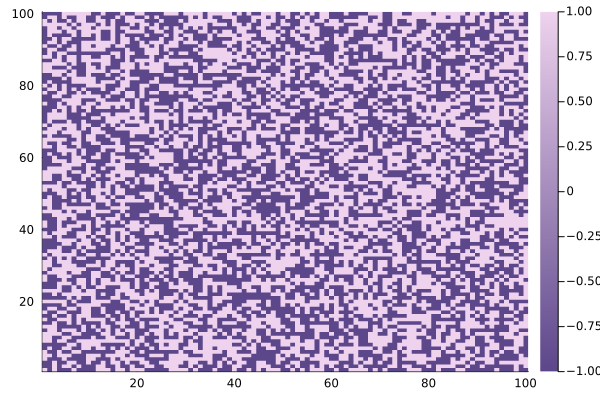

In [5]:
gryd , jey= Init(100,1)
heatmap(gryd, c = [:mediumpurple4 , :thistle2])


After L steps

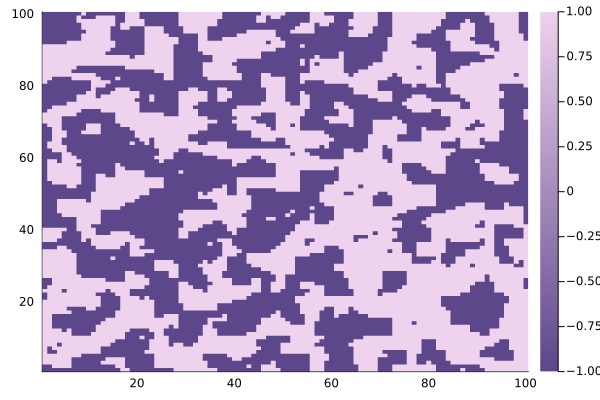

In [6]:

heatmap(IsingMetroPolice(gryd,100,50000, FindΔE, jey)[1] , c = [:mediumpurple4 , :thistle2] , legend = true)

Animation

In [ ]:
# IsinigAnime = @animate for L in 1:500
#     heatmap(IsingMetroPolice(gryd,100,200, FindΔE, jey)[1] , c = [:mediumpurple4 , :thistle2] , legend = true	
#     )
# end

# gif(IsinigAnime, fps = 15)

Calculating $M$, $\chi$ ,  $C_v$

In [5]:
function Calculator(n,j,runs)
    
    EList = [zeros(Float64, runs) for i in 1:n_thrds]
    MList = [zeros(Float64, runs) for i in 1:n_thrds]
    χ = 0.0
    Cᵥ = 0.0
    L = 1000000
    
    spingrid = [zeros(Int, n, n) for i in 1:n_thrds]

    @threads for i in 1:runs
        spingrid[threadid()] , Tinverse = Init(n,j)
        spingrid[threadid()] , EList[threadid()][i] , MList[threadid()][i] , counttemp = IsingMetroPolice(spingrid[threadid()] , n ,L ,FindΔE, Tinverse)
    end

    EListMerge = sum(EList)
    MListMerge = sum(MList)
    Cᵥ = var(EListMerge)
    χ = sqrt(var(MListMerge))
    return [Cᵥ, χ , mean(MListMerge) , mean(EListMerge)]./ (n^2)
end


        

Calculator (generic function with 1 method)

In [5]:
Calculator(10, 1,10)[3]

1.0

In [6]:

J_Itr=flatten((0:0.01:0.3,0.3:0.005:0.5,0.5:0.01:0.8))


Base.Iterators.Flatten{Tuple{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}}}((0.0:0.01:0.3, 0.3:0.005:0.5, 0.5:0.01:0.8))

In [6]:
data10 = Calculator.(10, J_Itr,100)

103-element Vector{Vector{Float64}}:
 [0.0, 0.07011534508338112, 0.08900000000000001, 0.0]
 [0.0006430707070707071, 0.0697052959453461, 0.0824, -0.00028]
 [0.003170547070707071, 0.06117073308256642, 0.0766, -0.0010719999999999998]
 [0.006779985454545458, 0.06468696963379904, 0.0812, -0.004488000000000002]
 [0.014819555555555556, 0.07017553747999412, 0.0908, -0.004320000000000001]
 [0.02174965656565658, 0.06381285770188332, 0.0808, -0.009280000000000004]
 [0.03296791272727276, 0.06972934689341223, 0.0862, -0.013008000000000006]
 [0.036789081212121225, 0.07910892631190379, 0.09939999999999999, -0.021336000000000008]
 [0.04755125010101013, 0.06947886823569546, 0.0964, -0.023232000000000003]
 [0.047510050909090905, 0.07318745821794907, 0.09539999999999998, -0.033336000000000005]
 [0.08537470707070711, 0.08475061455037754, 0.10460000000000001, -0.04352000000000001]
 [0.10675377777777782, 0.07680909037110363, 0.08560000000000001, -0.04444]
 [0.14341492363636385, 0.08288997210005246, 0.1114, 

In [7]:
data15 = Calculator.(15, J_Itr,100)

103-element Vector{Vector{Float64}}:
 [0.0, 0.03648351359087626, 0.05173333333333333, 0.0]
 [0.0006622412570145908, 0.036523196509577534, 0.05946666666666667, -0.00034488888888888904]
 [0.0028341469809203155, 0.037451046319598634, 0.051644444444444444, -0.0009671111111111112]
 [0.00783939232323233, 0.04129675076375678, 0.052977777777777776, -0.0026026666666666676]
 [0.0129609668237935, 0.03963409144460085, 0.05564444444444444, -0.006670222222222223]
 [0.019508866442199777, 0.04456101435670888, 0.059555555555555556, -0.010488888888888888]
 [0.024437811717171742, 0.04821004051010312, 0.06026666666666667, -0.012928000000000005]
 [0.03327834505050504, 0.04591558480294554, 0.06115555555555555, -0.01787022222222222]
 [0.0459156543209877, 0.04095977849422586, 0.05928888888888889, -0.02503111111111112]
 [0.0784793599999999, 0.0481470914154951, 0.0656, -0.03449599999999999]
 [0.07624949943883264, 0.051562908256989275, 0.06551111111111112, -0.04074666666666666]
 [0.10409326617283954, 0.049066181

In [7]:
data20 = Calculator.(20, J_Itr,100)

103-element Vector{Vector{Float64}}:
 [0.0, 0.028358945642950092, 0.035750000000000004, 0.0]
 [0.0008375208080808089, 0.035389463706223936, 0.04190000000000001, -0.000256]
 [0.003355636363636366, 0.032118153084755005, 0.0432, -0.0015800000000000009]
 [0.005829178181818186, 0.031125803709553534, 0.03965, -0.004428000000000001]
 [0.014825735757575776, 0.03309475224658173, 0.0487, -0.007352000000000004]
 [0.01988347474747472, 0.03561419958557558, 0.04425, -0.010219999999999998]
 [0.04498449454545451, 0.03683086513052098, 0.048049999999999995, -0.015276000000000003]
 [0.04260240161616163, 0.03536858590171324, 0.046349999999999995, -0.019516000000000002]
 [0.05917478787878795, 0.029798100068238707, 0.04045, -0.025440000000000015]
 [0.06275834181818166, 0.03393026121712926, 0.0495, -0.034451999999999976]
 [0.08993923232323192, 0.04143279821200552, 0.054299999999999994, -0.041019999999999966]
 [0.11193189333333323, 0.03435094429178583, 0.04875, -0.050842]
 [0.11841256727272681, 0.038537008317

In [17]:
datamatrix= hcat(data10...)
ListCᵥ10= datamatrix[1,:] ./100
Listχ10 = datamatrix[2,:] ./100
ListMeanM10 = datamatrix[3,:] ./100
ListMeanE10 = datamatrix[4,:] ./100
CSV.write("table10density.csv",  Tables.table(datamatrix))

"table10density.csv"

In [16]:
datamatrix= hcat(data15...)
ListCᵥ15= datamatrix[1,:] ./225
Listχ15 = datamatrix[2,:] ./225
ListMeanM15 = datamatrix[3,:] ./225
ListMeanE15 = datamatrix[4,:] ./225
CSV.write("table15density.csv",  Tables.table(datamatrix))

"table15density.csv"

In [8]:
datamatrix = hcat(data20...)
ListCᵥ20= datamatrix[1,:] ./400
Listχ20 = datamatrix[2,:] ./400
ListMeanM20 = datamatrix[3,:] ./400
ListMeanE20 = datamatrix[4,:] ./400
CSV.write("20new1m.csv",  Tables.table(datamatrix))

"20new1m.csv"

In [1]:
plot(collect(J_Itr),ListCᵥ10, markershape = :circle, markersize = 0.4, label = "10*10 grid")
plot!(collect(J_Itr),ListCᵥ15, markershape = :circle, markersize = 0.4, label = "15*15 grid")
plot!(collect(J_Itr),ListCᵥ20, markershape = :circle, markersize = 0.4, label = "20*20 grid")

plot!(xaxis = "J", yaxis = L"C_v", title = L"C_v \: over\: different\: J ")

LoadError: UndefVarError: J_Itr not defined

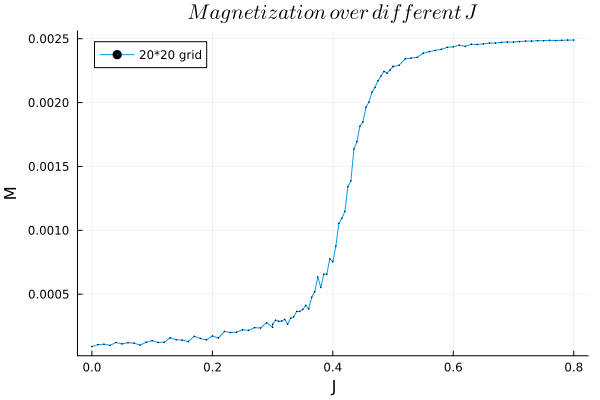

In [11]:
plot(collect(J_Itr),ListMeanM10, markershape = :circle, markersize = 0.4, label = "10*10 grid")
plot!(collect(J_Itr),ListMeanM15, markershape = :circle, markersize = 0.4, label = "15*15 grid")
plot(collect(J_Itr),ListMeanM20, markershape = :circle, markersize = 0.4, label = "20*20 grid")

plot!(xaxis = "J", yaxis = "M", title = L"Magnetization \: over \: different \: J ")

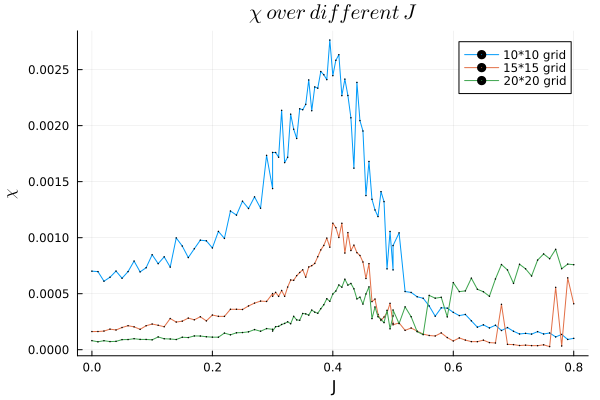

In [14]:
plot(collect(J_Itr),Listχ10, markershape = :circle, markersize = 0.4, label = "10*10 grid")
plot!(collect(J_Itr),Listχ15, markershape = :circle, markersize = 0.4, label = "15*15 grid")
plot!(collect(J_Itr),Listχ20, markershape = :circle, markersize = 0.4, label = "20*20 grid")

plot!(xaxis = "J", yaxis = L"\chi", title = L"\chi\;  over\; different\; J ")

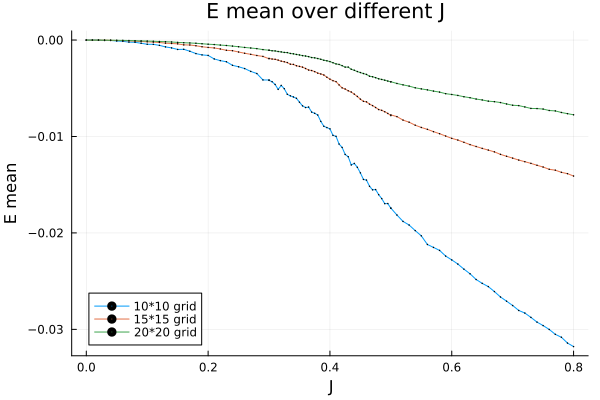

In [15]:
plot(collect(J_Itr),ListMeanE10, markershape = :circle, markersize = 0.4, label = "10*10 grid")
plot!(collect(J_Itr),ListMeanE15, markershape = :circle, markersize = 0.4, label = "15*15 grid")
plot!(collect(J_Itr),ListMeanE20, markershape = :circle, markersize = 0.4, label = "20*20 grid")
plot!(xaxis = "J", yaxis = "E mean", title = "E mean over different J ")

In [55]:
J_ItrList = collect(J_Itr)[30:58]
J_ItrListLn = log.(J_ItrList)
A= [ones(length(J_ItrListLn)) J_ItrListLn]
ParaCv10 = A \ log.(ListCᵥ10[30:58]) 

ParaCv15 = A \ log.(ListCᵥ15[30:58]) 

ParaCv20 = A \ log.(ListCᵥ15[30:58])  

Paraχ10 = A \ log.(Listχ10[30:58]) 

Paraχ15 = A \ log.(Listχ15[30:58]) 

Paraχ20 = A \ log.(Listχ20[30:58]) 

ParaMeanM10 = A \ log.(ListMeanM10[30:58]) 

ParaMeanM15 = A \ log.(ListMeanM15[30:58]) 

ParaMeanM20 = A \ log.(ListMeanM20[30:58]) 



2-element Vector{Float64}:
 2.748395082091011
 4.239515332526111

In [56]:
println(ParaCv10,ParaCv15,ParaCv20)
println(Paraχ10,Paraχ15,Paraχ20)
println(ParaMeanM10,ParaMeanM15,ParaMeanM20)

[6.18441566502815, 5.138523475092976][5.556665711202009, 4.567496813611983][5.556665711202009, 4.567496813611983]
[-4.632954903575239, 1.5018334458915092][-4.746662540322382, 2.4219536178559196][-4.8747356087114895, 3.042473199652]
[2.350066424096423, 3.273180598418299][2.8081053266968095, 4.047750446390775][2.748395082091011, 4.239515332526111]


Finding $\zeta$,

In [3]:
function CorrelationLength(n,j,L)
    
    
    spingrid , Tinverse = Init(n,j)
    IsingGrid = IsingMetroPolice(spingrid , n ,L ,FindΔE, Tinverse)[1]
    CorrelationList = zeros(n÷2)
    for i in 1:(n÷2)                            # Looping through half of the grid rows.
        CorrelationList[i] = AutoCorrelation(IsingGrid,i)
    end
    return CorrelationList
end

CorrelationLength (generic function with 1 method)

In [4]:
n = 256
function CoLenCalculator(n,J,L)
    AutoCoLists = []
    summ = zeros(n÷2)                            
    for i in 1:10
        push!(AutoCoLists,CorrelationLength(n,J,L))
    end
    for i in 1:(n÷2)                                 # Finding CorrelationLength length for 10 times and taking 
        for j in 1:10                                  #the mean for reducing noise
            summ[i] += AutoCoLists[j][i]
        end
    end
    MeanAutoCo= summ ./ 10
    CoLen = findfirst(x -> abs(x) <= 1/ℯ, MeanAutoCo)        #Finding Correlation Length
    return CoLen,MeanAutoCo
end




CoLenCalculator (generic function with 1 method)

3

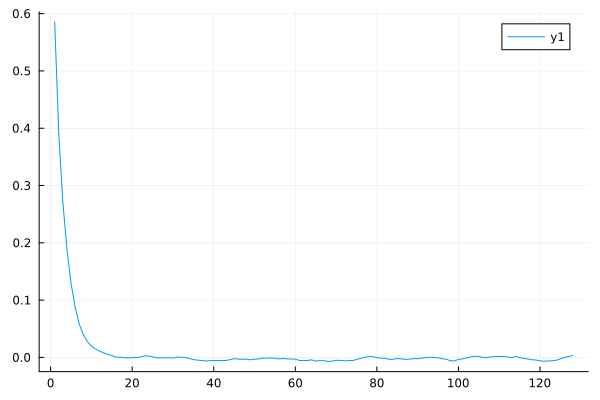

In [5]:
dota = CoLenCalculator(256,0.43,1000000)
print(dota[1])
plot(dota[2])

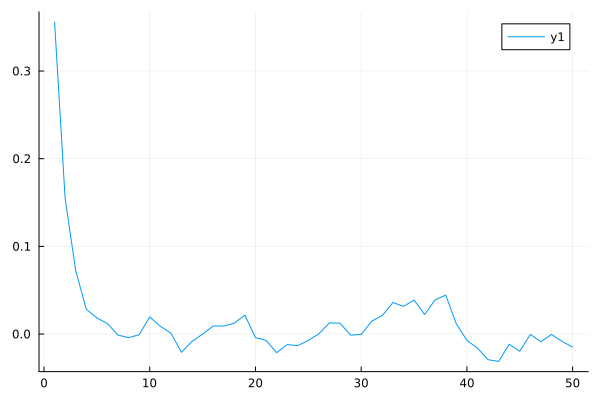

In [6]:
plot(CorrelationLength(100, 0.3, 1000000))

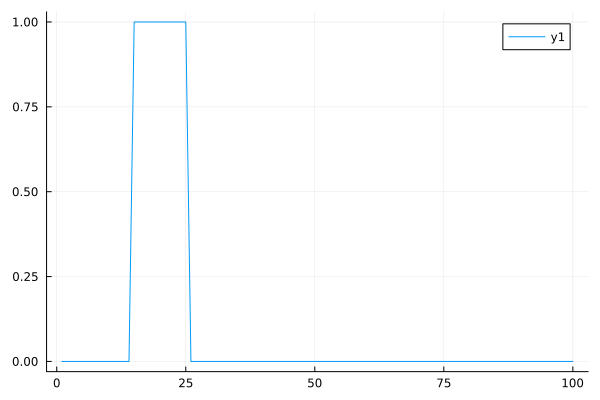

In [6]:
CoLenList = zeros(100)
for t in 35:45
    CoLenList[t] = CoLenCalculator(256,t/100,10000000)[1]
end
plot(CoLenList)
    

    

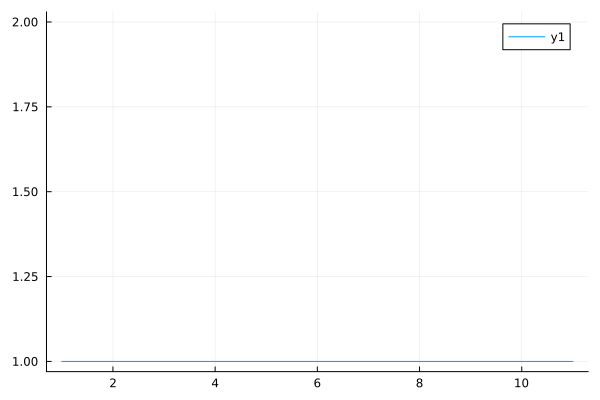

In [9]:
Plots.plot(CoLenList[35:45])